In [131]:
from IPython.display import clear_output
import time
import numpy as np
import pandas as pd
from scipy.stats import entropy   # KL divergence
import matplotlib.pyplot as plt
%matplotlib inline

# Qiskit
from qiskit import *
from qiskit.aqua import QuantumInstance
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import state_fidelity, random_statevector, hellinger_fidelity
## Noise
from qiskit.providers.aer import noise 

In [132]:
def prob_dist_haar(num_qubits, bin_num):
    """ This function creates the ideal distribution of fidelities of pairs of random quantum states sampled
        from the Haar distribution. 
        
        This is analytically given by the formula """
    points = np.linspace(0, 1, bin_num + 1) # we are taking one more number than the number of bins so that we can take the average number at each instance for the vvalue at that specific bin 
    haar = []
    const = (2**num_qubits) - 1
    power = const - 1
    for i in range(bin_num):
        haar.append(const*((1 - ((points[i] +points[i+1])/2))**power))
    haar_prob = haar/sum(haar)
    return haar_prob

In [133]:
def hellinger(dist_a, dist_b):
    """ Function for converting our distributions distribution A (dist_a) and distribution B (dist_b) into 
        dictionaries as accepted by the qiskit function hellinger_fidelity)() and returning the value of Hellinger 
        fidelity """
    fid = 0
    if len(dist_a) != len(dist_b):
        print("Both the distributions must be of same length");
    else:
        dict_a = {}
        dict_b = {}
        for i in range(len(dist_a)):
            dict_a[i] = dist_a[i]
            dict_b[i] = dist_b[i]
        fid = hellinger_fidelity(dict_a, dict_b)
    return(fid)

In [134]:
def expressibility(pqc, qr=None, trials=5000, bin_num=75, verbose=False, draw=False, quantum_instance=None):
    """ Function that takes in a parameterised quantum circuit and computes its expressibility based on the 
        number of trials and bin number 
        
        Number of trials is set to 5000 by default and number of bins to 75 based on the values given in the 
        paper for 4 qubit PQCs """
    
    # Initialisation 
    r1 = {}
    r2 = {}
    fidelities = []
    bins = []
    
    # Step 1 - Choosing and extracting information about the PQC
    num_params = pqc.num_parameters
    set_ = pqc.parameters
    num_qubits = pqc.num_qubits
    
    # Loop for Steps 2, 3, and 4 
    for j in range(trials):
        if verbose:
            if j%(trials/10)==0:
                print("{}% completed".format(int((j/trials)*100)))
            
        # Step 2 - forming two sets of random parameters for the PQC.
        for k in set_:
            # Creating two sets of random parameter values, each value ranging from 0 to 2*pi. 
            r1[k] = 2*np.pi*np.random.rand()
            r2[k] = 2*np.pi*np.random.rand()
        # Finding the states after applying these quantum circuits to a ground state
        circ_1 = pqc.bind_parameters(r1)
        circ_2 = pqc.bind_parameters(r2)
        if quantum_instance == None:
            backend = Aer.get_backend('statevector_simulator')
            job1 = execute(circ_1, backend)
            job2 = execute(circ_2, backend)
            v1 = job1.result().get_statevector()
            v2 = job2.result().get_statevector()
        else:
            tomo_circ1 = state_tomography_circuits(circ_1, qr)
            results_circ1 = quantum_instance.execute(tomo_circ1)
            v1 = DensityMatrix(StateTomographyFitter(results_circ1, tomo_circ1).fit(method='lstsq'))
            
            tomo_circ2 = state_tomography_circuits(circ_2, qr)
            results_circ2 = quantum_instance.execute(tomo_circ2)
            v2 = DensityMatrix(StateTomographyFitter(results_circ2, tomo_circ2).fit(method='lstsq'))
        
        # Step 3 - Calculate the Fidelity of these two states and store it

        fidelity = state_fidelity(v1, v2)
        fidelities.append(fidelity)
        
    print("Fidelity calculations have been completed.")
    clear_output()
    fidelities = np.array(fidelities)
    
    # Calculating the probability distribution of haar random state fidelities. 
    # Note: haar_fid is a probability distribution however fidelities is a frequency distribution
    haar_fid = prob_dist_haar(num_qubits=num_qubits, bin_num=bin_num)
    
    # Step 5 - plt.hist() automatically discretizes the fidelities frequency distribution and creates bins
    n, bins, _ = plt.hist(fidelities, bins=np.linspace(0,1, bin_num+1), alpha = 0.5)
    if draw:  
        plt.xlabel("Fidelities")
        plt.ylabel("Probability")
        plt.show()
    
    # Step 6 - Find the fidelity between both the states 
    pqc_fidelity_probs = n/trials
    expressibility = entropy(pqc_fidelity_probs, haar_fid)
    print("Expressibility of the pqc using Hellinger fidelity: {}".format(hellinger(pqc_fidelity_probs, haar_fid)))
    print("Expressibility of the pqc using KL divergence: {}".format(expressibility))
    return expressibility, fidelities, r1, r2

## PQC Test

In [135]:
def pqc_test(num_qubits=1, reps=1):
    """ Creating the Circuit B from Fig.1(a) to cross check the probability distribution """
    num_qubits = num_qubits            
    reps = reps
    num_params = int(2*num_qubits*reps)
    x = ParameterVector('z', length=num_params)  # creating a list of Parameters
    qr = QuantumRegister(num_qubits)
    variational_form = QuantumCircuit(qr)

    num = -1
    # defining our parametric form
    for _ in range(reps):
        for i in range(num_qubits):
            num = num + 1
            variational_form.h(i)
            variational_form.rz(x[num], i)
        
        for i in range(num_qubits):
            num = num + 1
            variational_form.rx(x[num], i)
    return variational_form, qr

In [87]:
qc, _ = pqc_test()
qc.draw()

┌───┐┌──────────┐┌──────────┐
q5_0: ┤ H ├┤ RZ(z[0]) ├┤ RX(z[1]) ├
      └───┘└──────────┘└──────────┘

In [140]:
def c3(num_qubits=4, reps=1):
    num_qubits = num_qubits            
    reps = reps
    num_params = int(((2*num_qubits) + num_qubits-1)*reps)
    x = ParameterVector('b', length=num_params)  # creating a list of Parameters
    qr = QuantumRegister(num_qubits)
    variational_form = QuantumCircuit(qr)

    num = -1
    # defining our parametric form
    for _ in range(reps):
        for i in range(num_qubits):
            num = num + 1
            variational_form.rx(x[num], i)
        
        for i in range(num_qubits):
            num = num + 1
            variational_form.rz(x[num], i)
            
        for i in range(num_qubits-1):
            num = num + 1
            variational_form.crz(x[num], num_qubits-i-1, num_qubits-i-2)
            
    return variational_form, qr

In [142]:
c3()[0].draw()

┌──────────┐┌──────────┐                        ┌───────────┐
q8_0: ┤ RX(b[0]) ├┤ RZ(b[4]) ├────────────────────────┤ RZ(b[10]) ├
      ├──────────┤├──────────┤            ┌──────────┐└─────┬─────┘
q8_1: ┤ RX(b[1]) ├┤ RZ(b[5]) ├────────────┤ RZ(b[9]) ├──────■──────
      ├──────────┤├──────────┤┌──────────┐└────┬─────┘             
q8_2: ┤ RX(b[2]) ├┤ RZ(b[6]) ├┤ RZ(b[8]) ├─────■───────────────────
      ├──────────┤├──────────┤└────┬─────┘                         
q8_3: ┤ RX(b[3]) ├┤ RZ(b[7]) ├─────■───────────────────────────────
      └──────────┘└──────────┘

In [144]:
c3()[1]

QuantumRegister(4, 'q9')

In [9]:
temp = []
for r in range(2):
    temp.append(np.random.rand())
print("z = [{}, {}]".format(temp[0], temp[1]))

z = [0.41984818504095733, 0.605726340023129]


In [10]:
set_ = qc.parameters
print(type(set_))

<class 'set'>


In [11]:
r1 = {}
r2 = {}
for k in set_:
    # Creating two sets of random parameter values, each value ranging from 0 to 2*pi. 
    r1[k] = 2*np.pi*np.random.rand()
    r2[k] = 2*np.pi*np.random.rand()

In [12]:
r1

{Parameter(z[0]): 3.03386414897261, Parameter(z[1]): 3.3301963140855504}

In [13]:
r2

{Parameter(z[0]): 3.601884247793598, Parameter(z[1]): 6.136619894907062}

In [16]:
for i in r2.values():
    print(i)

3.601884247793598
6.136619894907062


In [17]:
print("z = [3.601884247793598, 6.136619894907062]")

z = [3.601884247793598, 6.136619894907062]


In [21]:
circ_1 = qc.bind_parameters(r1)
circ_1.draw()

┌───┐┌────────────┐┌────────────┐
q_0: ┤ H ├┤ RZ(3.0339) ├┤ RX(3.3302) ├
     └───┘└────────────┘└────────────┘

In [22]:
circ_2 = qc.bind_parameters(r2)
circ_2.draw()

┌───┐┌────────────┐┌────────────┐
q_0: ┤ H ├┤ RZ(3.6019) ├┤ RX(6.1366) ├
     └───┘└────────────┘└────────────┘

In [23]:
backend = Aer.get_backend('statevector_simulator')
job1 = execute(circ_1, backend)
job2 = execute(circ_2, backend)
v1 = job1.result().get_statevector()
v2 = job2.result().get_statevector()

In [24]:
v1

array([0.00910782+0.69988406j, 0.06619669-0.711124j  ])

In [25]:
v2

array([-0.72820668+0.04638402j,  0.6318129 +0.26148808j])

In [26]:
state_fidelity(v1, v2)

0.9679165238556401

## Testing without noise 

In [138]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
from qiskit import quantum_info as qi

In [30]:
qc.draw()

┌───┐┌──────────┐┌──────────┐
q0_0: ┤ H ├┤ RZ(z[0]) ├┤ RX(z[1]) ├
      └───┘└──────────┘└──────────┘

In [32]:
qr2 = QuantumRegister(1)
qc2 = QuantumCircuit(qr2)
qc2.h(0)
qc2.draw()

┌───┐
q2_0: ┤ H ├
      └───┘

In [36]:
qc_tomo_circuits = state_tomography_circuits(qc2, qr2)
qc_tomo_circuits[0].draw()
# print(len(qc_tomo_circuits))

┌───┐ ░ ┌───┐┌─┐
q2_0: ┤ H ├─░─┤ H ├┤M├
      └───┘ ░ └───┘└╥┘
c2_0: ══════════════╩═

In [46]:
job = execute(qc_tomo_circuits, Aer.get_backend('qasm_simulator'), optimization_level=0, shots=5000)

In [57]:
print(type(job.result()))

<class 'qiskit.result.result.Result'>


In [106]:
density = StateTomographyFitter(job.result(),qc_tomo_circuits).fit(method='lstsq')

In [107]:
density

array([[0.50259993+0.j        , 0.49998648-0.00259993j],
       [0.49998648+0.00259993j, 0.49740007+0.j        ]])

In [108]:
np.linalg.eigvals(density)

array([1.00000000e+00+0.j, 7.87084648e-17+0.j])

## Testing with noise 

In [50]:
from qiskit import IBMQ

In [51]:
from qiskit.providers.aer import noise
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
noisy_backend = provider.get_backend('ibmq_bogota')
backend_noise = noise.device.basic_device_noise_model(noisy_backend.properties())
print ("Backend Noise Model of Bogota being used")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/basic_device_model.py:111: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  warnings.warn(


Backend Noise Model of Bogota being used


In [150]:
shots = 1000
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backend, shots=shots, 
                                   skip_qobj_validation=False,optimization_level=0,
                                   noise_model=backend_noise)

In [53]:
results_with_noise = quantum_instance.execute(qc_tomo_circuits)

In [58]:
print(type(results_with_noise))

<class 'qiskit.result.result.Result'>


In [116]:
density_noisy = StateTomographyFitter(results_with_noise, qc_tomo_circuits).fit(method="lstsq")

In [117]:
density_noisy

array([[0.521 +0.j    , 0.4862-0.0214j],
       [0.4862+0.0214j, 0.479 +0.j    ]])

In [118]:
np.linalg.eigvals(density_noisy)

array([0.9871236-1.73311074e-18j, 0.0128764+1.73311074e-18j])

In [83]:
from qiskit.quantum_info import state_fidelity, DensityMatrix, Statevector

In [119]:
state_fidelity(DensityMatrix(density), DensityMatrix(density_noisy))

0.9864073291382163

In [84]:
state_fidelity(DensityMatrix([[0.5, 0.5], [0.5, 0.5]]), Statevector([1/np.sqrt(2), 1/np.sqrt(2)]))

0.9999999999999998

In [72]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [82]:
np.linalg.eigvals(density)

array([ 1.00001492e+00+6.07029933e-18j, -1.47821783e-05-5.63661846e-18j])

In [81]:
print(a)

False


In [74]:
q2 = QuantumRegister(6)
bell = QuantumCircuit(q2)
bell.h(q2[3])
bell.cx(q2[3], q2[5])
print(bell)

t = time.time()

# Generate the state tomography circuits.
qst_bell = state_tomography_circuits(bell, [q2[3], q2[5]])

# Execute
job_ = qiskit.execute(qst_bell, Aer.get_backend('qasm_simulator'), shots=5000)
print('Time taken:', time.time() - t)

# Fit result
tomo_fitter_bell = StateTomographyFitter(job_.result(), qst_bell)

# Perform the tomography fit
# which outputs a density matrix
rho_fit_bell = tomo_fitter_bell.fit(method='lstsq')
# F_bell = qi.state_fidelity(rho_fit_bell, target_state_bell)
# print('State Fidelity: F = {:.5f}'.format(F_bell))

                
q3_0: ──────────
                
q3_1: ──────────
                
q3_2: ──────────
      ┌───┐     
q3_3: ┤ H ├──■──
      └───┘  │  
q3_4: ───────┼──
           ┌─┴─┐
q3_5: ─────┤ X ├
           └───┘
Time taken: 9.621612071990967


In [75]:
rho_fit_bell

array([[ 5.02612326e-01+0.00000000e+00j,  4.72320242e-04-3.74641289e-03j,
         4.69903144e-04+7.56640834e-05j,  4.97149578e-01-5.44303814e-03j],
       [ 4.72320242e-04+3.74641289e-03j,  2.20690550e-03+0.00000000e+00j,
        -5.16100685e-04+2.13026847e-03j, -5.00501105e-04+2.45668276e-03j],
       [ 4.69903144e-04-7.56640834e-05j, -5.16100685e-04-2.13026847e-03j,
         2.19874510e-03+0.00000000e+00j, -5.11517009e-04+1.19894829e-03j],
       [ 4.97149578e-01+5.44303814e-03j, -5.00501105e-04-2.45668276e-03j,
        -5.11517009e-04-1.19894829e-03j,  4.92982023e-01+0.00000000e+00j]])

In [78]:
np.trace(rho_fit_bell) == 1

True

## Testing with Noise 

In [124]:
qc_, qr_ = pqc_test(num_qubits=1, reps=1)
qc_.draw()

┌───┐┌──────────┐┌──────────┐
q6_0: ┤ H ├┤ RZ(z[0]) ├┤ RX(z[1]) ├
      └───┘└──────────┘└──────────┘

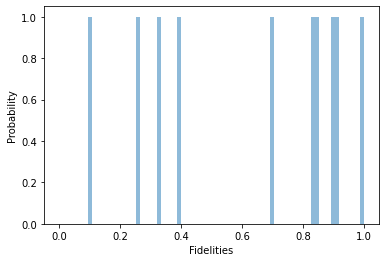

Expressibility of the pqc using Hellinger fidelity: 0.20322422957905584
Expressibility of the pqc using KL divergence: 2.014903020542264


In [130]:
exp_test_1, results_test_1, _, _ = expressibility(pqc=qc_, qr=qr_, trials=10, 
                                                  bin_num=75, quantum_instance=quantum_instance, draw=True)

## Trying with circuit 3, 1000 trails, 1 reps 

In [145]:
qc_3, qr_3 = c3()

In [146]:
qc_3.draw()

┌──────────┐┌──────────┐                        ┌───────────┐
q10_0: ┤ RX(b[0]) ├┤ RZ(b[4]) ├────────────────────────┤ RZ(b[10]) ├
       ├──────────┤├──────────┤            ┌──────────┐└─────┬─────┘
q10_1: ┤ RX(b[1]) ├┤ RZ(b[5]) ├────────────┤ RZ(b[9]) ├──────■──────
       ├──────────┤├──────────┤┌──────────┐└────┬─────┘             
q10_2: ┤ RX(b[2]) ├┤ RZ(b[6]) ├┤ RZ(b[8]) ├─────■───────────────────
       ├──────────┤├──────────┤└────┬─────┘                         
q10_3: ┤ RX(b[3]) ├┤ RZ(b[7]) ├─────■───────────────────────────────
       └──────────┘└──────────┘

In [147]:
qr_3

QuantumRegister(4, 'q10')

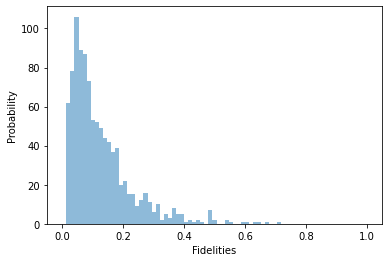

Expressibility of the pqc using Hellinger fidelity: 0.6134907509794789
Expressibility of the pqc using KL divergence: 0.5368887133501901
Time taken: 21011.074267864227


In [148]:
t = time.time()
exp_test_1, results_test_1, _, _ = expressibility(pqc=qc_3, qr=qr_3, trials=1000, 
                                                  bin_num=75, quantum_instance=quantum_instance, draw=True)
print('Time taken:', time.time() - t)

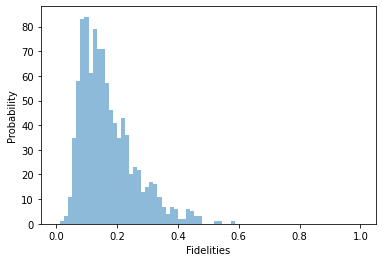

Expressibility of the pqc using Hellinger fidelity: 0.41696003792875846
Expressibility of the pqc using KL divergence: 1.1759232929154124
Time taken: 20744.96845293045


In [151]:
qc_3_2, qr_3_2 = c3(num_qubits=4, reps=2)

t_ = time.time()
exp_test_1_2, results_test_1_2, _, _ = expressibility(pqc=qc_3_2, qr=qr_3_2, trials=1000, 
                                                  bin_num=75, quantum_instance=quantum_instance, draw=True)
print('Time taken:', time.time() - t_)

In [158]:
1 - np.array([1, 2, 3, 4, 5])**2

array([  0,  -3,  -8, -15, -24])

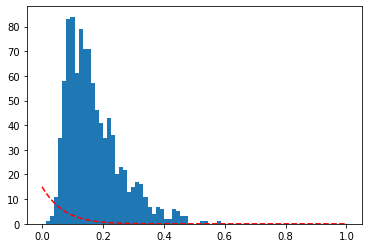

In [161]:
plt.hist(results_test_1_2, bins=np.linspace(0,1, 76))
x = np.linspace(0,1, 76)
plt.plot(x,15*((1-x)**(14)),'r--')
plt.show()

## Testing without noise to compare results